# Reinforcement Learning - Winter Semester 2025/26

# Exercise 2: Policy Gradients

---

> **Reinforcement Learning** in Winter Semester 2025/2026
>
> - Prof. Gerhard Neumann and Prof. Rudolf Lioutikov
> - Instructor for this exercise: Tai Hoang (tai.hoang@kit.edu)
> 
> ⚠️ For general questions about the exercises, please post in the Ilias forum so we can answer them once for all students. Only use email for individual questions whose answers are not relevant to all students.

---

# Group Submission

The exercise sheets can be submitted in groups of up to **3 students**. **Each person in the group must upload the final version via Ilias**. It is not sufficient if only one person from the group does this. It is possible to join a new group during the semester if your own group dissolves early. Each group must upload their own solution, and we will check submissions for duplicates.

Groups are automatically recorded, so **please enter the u-identifiers of your group members in the following cell.** If your group consists of only 2 students, or if you are submitting alone, leave the remaining fields empty. Here is an **example** for a group consisting of uabcd and uefgh:

_U-identifiers of group members:_G-078

_Member 1: urphy

_Member 2: ubhqg

_Member 3:_

U-identifiers of group members:

Member 1:

Member 2:

Member 3:

# Auto-grading

We use an auto-grading system that automatically analyzes your submitted Jupyter Notebooks and checks them for correctness using hidden tests. These tests determine the points you receive for the exercise sheet.

To ensure auto-grading works smoothly, please note the following:

- The notebook must have the filename "ex_01_tabular_rl.ipynb"
- Upload PDF and Jupyter Notebook separately on Ilias (not as a zip!)
- Before submitting a notebook, test that everything runs without errors from start to finish.
- Cells marked with "##### DO NOT CHANGE #####" must not be edited or deleted
- Your solution must be entered in the correct cell (marked with "# YOUR CODE HERE").
  - Please delete the **NotImplementedError!**
- Generally, **do not delete any cells** and **do not add any cells**. The cells where your solution should be entered already exist (marked with "# YOUR CODE HERE").
- There may be seemingly empty cells that are also marked with "##### DO NOT CHANGE #####". These must also not be edited or deleted.
  - If you do modify them, auto-grading will not work and you will receive no points.
  - We will be strict about this and make no exceptions if someone modifies cells clearly marked as readonly!
- The Jupyter Notebooks have inline tests (visible to you) that check your result for basic correctness.
  - These are primarily for you to identify and correct errors.
  - However, the inline tests you can see in the notebook are not the tests used for grading!
  - The inline tests are a necessary but not sufficient condition to receive points when grading the task!

## Local Setup

If you prefer to work locally, see the following instructions for setting up Python in a virtual environment.
You can then ignore the instructions in "Colab Setup".

If you haven't yet, create a [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) environment using:
```
conda create --name rl_exercises
conda activate rl_exercises
```
Torch recommends installation using conda rather than pip, so run:
```
conda install pytorch cpuonly -c pytorch
```
If you have a CUDA-enabled GPU and would like to use it, visit [the installation page](https://pytorch.org/get-started/locally/) to see the options available for different CUDA versions.
The remaining dependencies can be installed with pip:
```
pip install matplotlib numpy "gymnasium[classic-control, other]"
```

Even if you are running the Jupyter notebook locally, please run the code cells in **Colab Setup**, because they define some global variables required later.

## Colab Setup

Google Colab provides you with a temporary environment for python programming.
While this conveniently works on any platform and internally handles dependency issues and such, it also requires you to set up the environment from scratch every time.
The "Colab Setup" section below will be part of **every** exercise and contains utility that is needed before getting started.

There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
Any changes you make to the Jupyter notebook itself should be saved to your Google Drive.
We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [1]:
##### DO NOT CHANGE #####
"""Your work will be stored in a folder called `rl_ws25` by default to prevent Colab 
instance timeouts from deleting your edits.
We do this by mounting your google drive on the virtual machine created in this colab 
session. For this, you will likely need to sign in to your Google account and allow
access to your Google Drive files.
"""

from pathlib import Path
try:
    from google.colab import drive
    drive.mount("/content/gdrive")
    COLAB = True
except ImportError:
    COLAB = False

# Create paths in your google drive
if COLAB:
    DATA_ROOT = Path("/content/gdrive/My Drive/rl_ws25")
    DATA_ROOT.mkdir(exist_ok=True)
else:
    DATA_ROOT = Path.cwd() / "rl_ws25"

# Install **python** packages
if COLAB:
    %pip install matplotlib numpy "gymnasium[classic-control, other]" torch

##### DO NOT CHANGE #####

# Exercise 2: Policy Gradient Methods

In this homework we will be mainly working on Policy gradients (Lecture 5) 
and Natural Policy Gradients (Lecture 6). We are going to implement the 
REINFORCE, the Policy Gradient Theorem and the Natural Gradient algorithms. 

All homeworks are self-contained.
They can be completed in their respective notebooks.
Please fill in any missing code or answer any questions that are marked with `# YOUR CODE HERE` statements.
Questions not marked with `# YOUR CODE HERE` are self-test questions and do **not** need to be answered for points.
To edit and re-run code, you can simply edit and restart the code cells below.
When you are finished, you will need to submit the notebook file via Ilias.

We start by importing all the necessary python modules and defining some helper functions which you do not need to change.
Still, make sure you are aware of what they do.

In [2]:
##### DO NOT CHANGE #####
%matplotlib inline

import time
from dataclasses import dataclass
from typing import Sequence

from IPython import display
import matplotlib.pyplot as plt
import numpy as np


SEED = 2

# specify the path to save the recordings of this run to.
DATA_PATH = DATA_ROOT / "exercise_2" / time.strftime("%Y-%m-%d_%H-%M")


def save_figure(fig: plt.Figure, save_name: str) -> None:
    """Saves a figure into your google drive folder or local directory"""
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    path = DATA_PATH / (save_name + ".png")
    
    # DO NOT CHANGE: Turn off save_figure
    # fig.savefig(str(path))


##### DO NOT CHANGE #####

## Linear System and Quadratic Reward Function
In this exercise we will consider a relatively simple type of environment, a linear dynamical system with a quadratic reward function.
Note that this environment is deterministic.
The learning agent does not have any information about the system dynamics and the reward function. 

The linear dynamics are described as follows:

\begin{align}
      \boldsymbol{s'} = 
       \boldsymbol{As} + \boldsymbol{Ba},
\end{align}
where $\boldsymbol{s'}$ denotes the state in the next time step and $\boldsymbol{a}$ is the action input to the system. The identites of the system are given as 
\begin{align}
    \boldsymbol{A} = \begin{bmatrix}
                        1 & 0.1\\
                        0 & 0.99
                      \end{bmatrix}, ~~~~~
     \boldsymbol{B} = \begin{bmatrix}
                        0 \\
                        0.1 
                       \end{bmatrix}.
\end{align}
Thus, we have a two dimensional state-space and a one dimensional action space.

The immediate reward function, is given as
\begin{align}
    r(\boldsymbol{s_t}, a_t) = -\boldsymbol{s_t}^T\boldsymbol{M}\boldsymbol{s_t} - a_t^2Q,
\end{align}
resulting in an episode reward
\begin{align}
    R(\tau) = \sum_t r(\boldsymbol{s_t}, a_t)
\end{align}

The code block which describes the linear system and its corresponding quadratic reward function 
is given below.

In [3]:
##### DO NOT CHANGE #####
S_DIM = 2
A_DIM = 1
HORIZON = 50


class LinEnv:
    _A = np.array([[1, 0.1], [0, 0.99]])
    _B = np.array([0, 0.1])
    _M = np.array([[10, 0], [0, 1]])
    _Q = np.array([1])
    _s_init = np.array([2, 1])

    def __init__(self) -> None:
        self.t = 0
        self._s = np.array([2, 1])
        self.s_max = np.ones(2) * 12
        self.s_min = -np.ones(2) * 12
        self.a_max = 8
        self.a_min = -8

    def reset(self) -> np.ndarray:
        self._s = self._s_init
        self.t = 0
        return self._s.copy()

    def step(self, action: np.ndarray) -> tuple[np.ndarray, float]:
        reward = -self._s.T @ self._M @ self._s - action.T * self._Q * action
        clipped_action = np.clip(action, self.a_min, self.a_max)
        self._s = self._A @ self._s + self._B * clipped_action
        self._s = np.clip(self._s, self.s_min, self.s_max)
        self.t += 1
        return self._s.copy(), reward.item()


linear_env = LinEnv()

##### DO NOT CHANGE #####

## Linear Controller
We consider a linear, stochastic controller (the policy) of the form
\begin{align}
    \pi(a|\boldsymbol{s}) = \mathcal{N}(a|\boldsymbol{Ks}, \sigma^2) =\frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{1}{2}\frac{(a-\boldsymbol{Ks})^2}{\sigma^2}},
\end{align}
where $\boldsymbol{K} = [k_1, k_2]$ and $\sigma$ are the learnable parameters.
Our learning algorithms will optimize these parameters.
Note that since the environment is deterministic, the policy is the only source of stochasticity in our problem.

The following code defines the linear controller:

In [4]:
##### DO NOT CHANGE #####
class LinPolicy:
    _params: np.ndarray
    _K: np.ndarray
    _std: np.ndarray  # standard deviation, i.e. sigma

    def __init__(self):
        self._K = np.zeros(S_DIM)
        self._std = np.ones(A_DIM)
        self.update_params(np.array([-10, -10, 1]))

    @property
    def params(self) -> np.ndarray:
        # return a copy so that params cannot be modified externally
        return self._params.copy()

    @property
    def n_params(self) -> int:
        return self._params.shape[0]

    def update_params(self, params: np.ndarray) -> None:
        assert len(params) == S_DIM + A_DIM
        self._K[:] = params[:S_DIM]
        self._std[:] = params[S_DIM:]
        self._params = params

    def get_mean(self, state: np.ndarray) -> np.ndarray:
        # expand dims so that dimension matches that of action
        # dot product removes one dimension
        return np.expand_dims(state @ self._K, axis=-1)

    def sample(self, state: np.ndarray, rng: np.random.Generator) -> np.ndarray:
        mean = self.get_mean(state)
        action = rng.normal(mean, np.abs(self._std))
        return action

    def grad_log_pi(self, states: np.ndarray, actions: np.ndarray) -> np.ndarray:
        """Get the gradient of the log probability of the given action(s) in the given state(s).
        :param states: np.ndarray [..., S_DIM], where S_DIM is the state dimension
        :param actions: np.ndarray [..., A_DIM], where A_DIM is the action dimension
        """
        std_inv = 1 / (self._std + 1e-20)
        z = actions - self.get_mean(states)
        grad_K = z * states * (std_inv**2)
        grad_sigma = -std_inv + (z**2) * (std_inv**3)
        return np.concatenate((grad_K, grad_sigma), axis=-1)

##### DO NOT CHANGE #####

Because our policy only contains 2 optimizable parameters, we can easily visualize the loss landscape.
This is usually not possible when working with neural networks with thousands or millions of parameters.

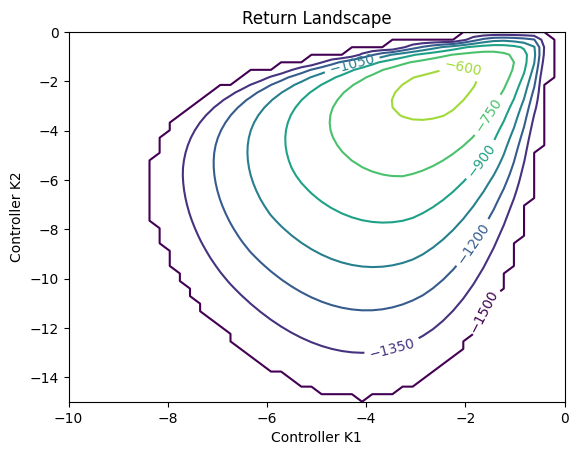

In [5]:
##### DO NOT CHANGE #####
def evaluate_policy(policy: LinPolicy, env: LinEnv) -> float:
    """Evaluate policy and return mean sum of rewards over the horizon. The policy is evaluated without variance, making the result deterministic."""
    ep_rewards = 0.0
    s = env.reset()
    for _ in range(HORIZON):
        a = policy.get_mean(s)
        s, r = env.step(a)
        ep_rewards += r
    return ep_rewards


N_POINTS = 50


def get_return_contours() -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute reward for policies with all combinations of parameters between b_min and b_max
    in steps of n_points. The policy is tested with the mean predicted action and zero variance.
    Since this is result is deterministic, each policy is only tested once.
    :return:
        k1s: np.ndarray [n_points]: values of k1 tested
        k2s: np.ndarray [n_points]: values of k2 tested
        rewards: np.ndarray [n_points, n_points]: reward for each policy
    """
    test_env = LinEnv()
    test_policy = LinPolicy()
    k1s = np.linspace(start=-10, stop=0, num=N_POINTS)
    k2s = np.linspace(start=-15, stop=0, num=N_POINTS)
    rewards = np.zeros((N_POINTS, N_POINTS))
    for i, k1 in enumerate(k1s):
        for j, k2 in enumerate(k2s):
            c_params = np.array([k1, k2, 1])
            test_policy.update_params(c_params)
            rewards[j, i] = evaluate_policy(
                policy=test_policy,
                env=test_env,
            )
    rewards = np.clip(rewards, -1500, 1500)
    return k1s, k2s, rewards


K1S, K2S, REWARDS = get_return_contours()


def plot_return_contours(ax):
    contour_set = ax.contour(*np.meshgrid(K1S, K2S), REWARDS)
    ax.clabel(contour_set, inline=True, fontsize=10)
    ax.set(title="Return Landscape", xlabel="Controller K1", ylabel="Controller K2")


# show contour plot of returns over the two optimizable parameters of controller
fig, ax = plt.subplots()
plot_return_contours(ax)

##### DO NOT CHANGE #####

## Policy Gradient Algorithms

Next, we will create a base class for policy gradient algorithms, which all have the same structure.
This structure is generally:

---

- **Repeat**  For $k=1, 2, \dots$
    - `collect_policy_samples()`: Run policy to sample trajectories \{$\tau_i$\}, ${i=1,...,N}$ from $\pi_{\boldsymbol{\theta}}(a|\boldsymbol{s})$
    - `estimate_grad()`: Estimate the gradient $\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
    - `grad_ascent_step()`: Update the parameters according to the estimated $\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$

- **Until convergence**

---

Based on this general structure, in the following we define a base class `PolicyGradientAlgo`, which contains shared attributes and functions.
The function `train` implements the main algorithm loop.
In this exercise, we will use various learning rates (`lr`) for various algorithms, with and without baselines.
The parameters `n_iters` and `batch_size` stay the same for the algorithms.
Also note that for this continuous control problem, the discount factor $\gamma$ is omitted since we set it to $1.0$.


In [6]:
##### DO NOT CHANGE #####
@dataclass
class TrainingResults:
    test_rewards: np.ndarray
    grad_estimates: np.ndarray
    parameters: np.ndarray


class PolicyGradientAlgo:
    def __init__(
        self,
        env: LinEnv,
        policy: LinPolicy,
        n_iters: int,
        batch_size: int,
        lr: float,
        baseline: bool = False,
    ) -> None:
        self.env = env  # current environment
        self.policy = policy  # current policy object
        self.n_iters = n_iters  # number of total iterations
        self.batch_size = batch_size  # number of traj. samples per iteration
        self.lr = lr  # learning rate
        self.baseline = baseline  # whether to use baseline or not

    def train(
        self,
        fig,
        line_rewards,
        line_grads,
        line_params,
        points_params,
        final_params,
    ) -> TrainingResults:
        """
        This function will perform the main loop of the policy gradient algorithms.
        For plotting and saving purposes, it will return the estimated gradients,
        the test rewards and the parameters of each iteration.
        :return:
            TrainingResults:
                estimated_grads: np.ndarray [n_iters x n_params]
                test_rewards: np.ndarray [n_iters]
                parameters: np.ndarray[n_iters+1 x n_params]
        """
        # initialize random state
        rng = np.random.default_rng(SEED)

        # initialize variables to store training results
        iters = []
        test_rewards = []
        grads = []
        parameters = [self.policy.params]

        for k in range(self.n_iters):
            iters.append(k + 1)
            states, actions, rewards = self.collect_policy_samples(rng)
            grads.append(self.estimate_grad(states, actions, rewards))
            parameters.append(self.grad_ascent_step(grads[-1], states, actions))
            self.policy.update_params(parameters[-1])
            test_rewards.append(evaluate_policy(policy=self.policy, env=self.env))

            if k % 10 == 9 or k == (self.n_iters - 1):
                # update plots
                display.clear_output(wait=True)
                line_rewards.set_data(iters, test_rewards)
                # average gradient over params
                mean_abs_grads = np.abs(grads).mean(axis=-1)
                line_grads.set_data(iters, mean_abs_grads)
                parameters_np = np.stack(parameters).T[:2]
                line_params.set_data(parameters_np)
                points_params.set_data(parameters_np)
                display.display(fig)

        # update plots
        final_params.set_data(parameters_np[:, -1:])

        # clear duplicate plot
        display.clear_output()

        return TrainingResults(
            np.stack(test_rewards), np.stack(grads), np.stack(parameters)
        )

    def collect_policy_samples(self, rng: np.random.Generator):
        states = np.zeros((self.batch_size, HORIZON, S_DIM))
        actions = np.zeros((self.batch_size, HORIZON, A_DIM))
        rewards = np.zeros((self.batch_size, HORIZON))

        for j in range(self.batch_size):
            state = self.env.reset()
            for t in range(HORIZON):
                states[j, t] = state
                actions[j, t] = self.policy.sample(state, rng)
                state, rewards[j, t] = self.env.step(actions[j, t])

        return states, actions, rewards

    def estimate_grad(
        self,
        states: np.ndarray,
        actions: np.ndarray,
        rewards: np.ndarray,
    ) -> np.ndarray:
        """This function returns the gradient estimate of the return.
        :param rewards: all training rewards of the last iteration:
            np.ndarray [batch_size x HORIZON]
        :param states: all states of the last iteration:
            np.ndarray [batch_size x HORIZON x S_DIM], where S_DIM is the state dimension
        :param actions: all taken actions of the last iteration:
            np.ndarray [batch_size x HORIZON x A_DIM], where A_DIM is the action dimension
        :return: grad_estimate: the estimated gradient: np.ndarray [n_params]
        """
        raise NotImplementedError

    def grad_ascent_step(
        self,
        grad_estimates: np.ndarray,
        states: np.ndarray | None = None,
        actions: np.ndarray | None = None,
    ):
        """This function performs the gradient ascent step.
        :param grad_estimates: estimates of the gradients for all parameters:
            np.ndarray [n_params]
        :param states all states of the last iteration:
            np.ndarray [batch_size x HORIZON x S_DIM], where S_DIM is the state dimension
        :param actions all taken actions of the last iteration:
            np.ndarray [batch_size x HORIZON x A_DIM], where A_DIM is the action dimension
        :return: updated policy parameters: np.ndarray [n_params]
        """
        return self.policy.params + self.lr * grad_estimates


def create_figure(n_iters: int):
    fig, (ax_returns, ax_grads, ax_contour) = plt.subplots(1, 3, figsize=(12, 5))
    fig.subplots_adjust(wspace=0.3)
    ax_returns.set(title="Returns", xlabel="Iterations", ylabel="Mean Rewards")
    ax_returns.set_xlim(0, n_iters)
    ax_returns.set_ylim(-2500, -500)
    ax_grads.set(
        title="Mean Abs Gradient",
        xlabel="Iterations",
        ylabel="Mean of Parameter Gradients",
    )
    ax_grads.set_xlim(0, n_iters)
    ax_grads.set_yscale("log")
    ax_grads.set_ylim(1, 5000)
    plot_return_contours(ax_contour)
    return fig, (ax_returns, ax_grads, ax_contour)


def add_method(axs, label: str, color: str):
    ax_returns, ax_grads, ax_contour = axs
    line_rewards, *_ = ax_returns.plot([], [], label=label, color=color)
    line_grads, *_ = ax_grads.plot([], [], label=label, color=color)
    line_params, *_ = ax_contour.plot([], [], label=label, color=color, alpha=0.5)
    points_params, *_ = ax_contour.plot([], [], "x", color=color, alpha=0.5)
    final_params, *_ = ax_contour.plot([], [], "x", color="red")
    ax_returns.legend()
    return line_rewards, line_grads, line_params, points_params, final_params


def plot_all_results(
    axs,
    results: Sequence[TrainingResults],
    labels: Sequence[str],
    colors: Sequence[str],
):
    ax_returns, ax_grads, ax_contour = axs
    for result, label, color in zip(results, labels, colors):
        iters = np.arange(len(result.test_rewards)) + 1
        ax_returns.plot(iters, result.test_rewards, label=label, color=color)
        mean_abs_grads = np.abs(result.grad_estimates).mean(axis=-1)
        ax_grads.plot(iters, mean_abs_grads, color=color)
        ax_contour.plot(
            result.parameters[:, 0],
            result.parameters[:, 1],
            color=color,
            alpha=0.5,
        )
        ax_contour.plot(
            result.parameters[:, 0],
            result.parameters[:, 1],
            "x",
            color=color,
            alpha=0.5,
        )
        ax_contour.plot(
            result.parameters[-1, 0],
            result.parameters[-1, 1],
            "x",
            color="r",
        )

    for ax in axs:
        # Shrink all axes' height by 10% on the bottom
        box = ax.get_position()
        ax.set_position(
            [box.x0, box.y0 + box.height * 0.15, box.width, box.height * 0.85]
        )

    ax_returns.legend(
        loc="upper left",
        bbox_to_anchor=(0.2, -0.15),
        fancybox=True,
        shadow=True,
        ncol=3,
    )

##### DO NOT CHANGE #####

## Task 1: REINFORCE (3 Points)
We start with the most basic algorithm, **REINFORCE**. The **pseudocode** is given as

---

- **Repeat**  For $k=1, 2, \dots$
    - Run policy to sample trajectories \{$\tau_i$\}, ${i=1,...,N}$ from $\pi_{\boldsymbol{\theta}}(a|\boldsymbol{s})$
    - Estimate the gradient:
$\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}) \approx \frac{1}{N}\sum_i^N \left(\sum_t^H \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a_{i,t}|\boldsymbol{s}_{i,t})\right)\left(\sum_t^H r(\boldsymbol{s}_{i,t}, a_{i,t})\right)$
    - Update the parameters:
$\boldsymbol{\theta}\leftarrow \boldsymbol{\theta} + \alpha \nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$

- **Until convergence**

---

The following class inherits from the `PolicyGradientAlgo` class and only needs to override the function `estimate_grad` according to the pseudo code given above.
This function estimates the gradient of the return with respect to the parameters of the policy. 

Your task is to implement the `estimate_grad` function according to the pseudocode shown above (**Don't implement `grad_ascent_step()`!**).
Through the object attribute `self.baseline`, we decide if we would like to estimate the gradient with or without a baseline. 
Make sure that both options are working in your code.

Use the following baseline
\begin{align}
    b = \frac{1}{N} \sum_i^N \sum_t^H r(\boldsymbol{s}_{i,t}, a_{i,t})
\end{align}

*Hint: To get the gradient of the log policy for current state $\boldsymbol{s}_{i,t}$ and current action $a_{i,t}$ from the rollout i at time step t, you will need to call `self.policy.grad_log_pi(current_state, current_action)`, where current_state is $\boldsymbol{s}_{i,t}$ and current action is $a_{i,t}$.*

After you completed the implementation, run the cell.
During training, it plots the reward curve, the magnitude of the gradients, and the trajectory of the parameters through the parameter space.

*Hint: If your algorithm learns with a baseline and doesn't learn without a baseline, don't worry, it probably won't.*
*Continue on to the self-test questions, which should help you verify if your implementation is correct even if it doesn't learn.*

In [7]:
class REINFORCE(PolicyGradientAlgo):
    def estimate_grad(
        self,
        states: np.ndarray,
        actions: np.ndarray,
        rewards: np.ndarray,
    ) -> np.ndarray:
        """This function returns the gradient estimate of the return.
        :param rewards: all training rewards of the last iteration:
            np.ndarray [batch_size x HORIZON]
        :param states: all states of the last iteration:
            np.ndarray [batch_size x HORIZON x S_DIM], where S_DIM is the state dimension
        :param actions: all taken actions of the last iteration:
            np.ndarray [batch_size x HORIZON x A_DIM], where A_DIM is the action dimension
        :return: grad_estimate: the estimated gradient: np.ndarray [n_params]
        """
        ## Hint: you need to compute the returns and the baseline (if needed), then the grad_estimate
        # if self.baseline:
        #     returns = ...
        # grad_estimate = ...
        
        # YOUR CODE HERE
        N,H, _ = states.shape

        print("N ", N)
        print("H ", H)
        if self.baseline:
            b = 1/N * np.sum(rewards)
        else:
            b = 0.0
 
        grad_log_pi = np.sum(self.policy.grad_log_pi(states,actions), axis=1)
        print("grad log ", grad_log_pi.shape)

        R = np.sum(rewards, axis=1) - b
        print("R ", R.shape)

        inner_product = grad_log_pi.T * R
        print("product ", inner_product.shape)

        grad_estimate = 1/N * np.sum(inner_product,axis=1)
        print(grad_estimate)

        assert grad_estimate.shape == (3,)
        return grad_estimate

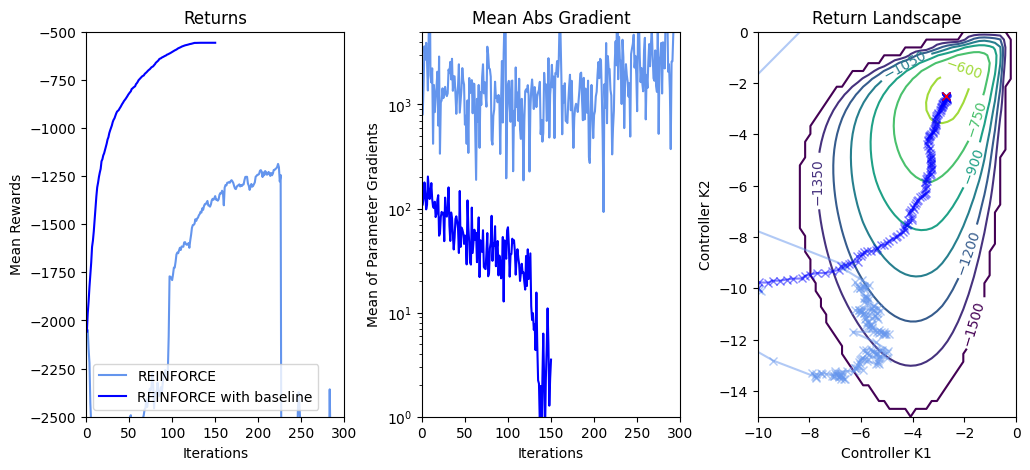

In [8]:
##### DO NOT CHANGE #####
N_ITERS = 300
N_ITERS_W_BASELINE = 150
BATCH_SIZE = 25

fig, axs = create_figure(n_iters=N_ITERS)
lines = add_method(axs, label="REINFORCE", color="cornflowerblue")

reinforce = REINFORCE(
    env=linear_env,
    policy=LinPolicy(),
    n_iters=N_ITERS,
    batch_size=BATCH_SIZE,
    lr=1e-4,
    baseline=False,
)
reinforce_results = reinforce.train(fig, *lines)

lines = add_method(axs, label="REINFORCE with baseline", color="blue")

reinforce_with_baseline = REINFORCE(
    env=linear_env,
    policy=LinPolicy(),
    n_iters=N_ITERS_W_BASELINE,
    batch_size=BATCH_SIZE,
    lr=1e-3,
    baseline=True,
)
reinforce_with_baseline_results = reinforce_with_baseline.train(fig, *lines)

save_figure(fig, "reinforce")

##### DO NOT CHANGE #####

In [9]:
##### DO NOT CHANGE #####
# ID: test_ex_1 - possible points: 3

# Test cell for REINFORCE implementation
test_env_reinforce = LinEnv()
test_policy_reinforce = LinPolicy()
test_policy_reinforce.update_params(np.array([-5, -5, 1]))

# Test REINFORCE without baseline
reinforce_test = REINFORCE(
    env=test_env_reinforce,
    policy=test_policy_reinforce,
    n_iters=1,
    batch_size=5,
    lr=1e-4,
    baseline=False,
)
rng_test = np.random.default_rng(SEED)
states_test, actions_test, rewards_test = reinforce_test.collect_policy_samples(rng_test)
grad_test = reinforce_test.estimate_grad(states_test, actions_test, rewards_test)

assert grad_test.shape == (3,), "Gradient should have shape (3,) for 3 parameters"
assert not np.all(grad_test == 0), "Gradient should not be all zeros"
assert np.all(np.isfinite(grad_test)), "Gradient should not contain NaN or inf"

# Test REINFORCE with baseline
reinforce_test_baseline = REINFORCE(
    env=test_env_reinforce,
    policy=LinPolicy(),
    n_iters=1,
    batch_size=5,
    lr=1e-3,
    baseline=True,
)
grad_test_baseline = reinforce_test_baseline.estimate_grad(states_test, actions_test, rewards_test)
assert grad_test_baseline.shape == (3,), "Gradient with baseline should have shape (3,)"
assert np.all(np.isfinite(grad_test_baseline)), "Gradient with baseline should not contain NaN or inf"

print("✓ Basic tests passed for REINFORCE")


##### DO NOT CHANGE #####

N  5
H  50
grad log  (5, 3)
R  (5,)
product  (3, 5)
[-605.93442356 2759.40869693 -338.21173573]
N  5
H  50
grad log  (5, 3)
R  (5,)
product  (3, 5)
[ 60.68440354  -1.57273436 547.18829812]
✓ Basic tests passed for REINFORCE


### Self-Test Questions (optional)

Compare the performance of the algorithm with and without a baseline.
Notice that with a baseline, we use a learning rate of $10^{-3}$, whereas without a baseline, we use a learning rate of $10^{-4}$.
Why is this necessary?

Obviously REINFORCE without a baseline is not a very reliable algorithm.
What happens if you decrease or increase the learning rate?
Is it possible to find a learning rate that converges to a better policy without making learning unstable?
Don't forget to try different random seeds (e.g. `SEED = 5`).

What happens if you increase the batch size?
Why does this tend to stabilize training?
How much do you need to increase the batch size so that the policy never makes a "jump" across parameter space?

What is the role of the stochastic policy here?
If the environment is deterministic, why should we complicate things by adding randomness to the policy?

## Task 2: Policy Gradient Theorem (3 Points)

**REINFORCE** suffers from high variance in the gradient estimates.
One way to reduce this high variance is to exploit the temporal structure of the trajectory when estimating returns.
This means using the Monte-Carlo estimate of the return to go from the current state, instead of the total return for the whole trajectory.
The pseudo code is given as

---

- **Repeat**  For $k=1, 2, \dots$
    - Run policy to sample trajectories \{$\tau_i$\}, ${i=1,...,N}$ from $\pi_{\boldsymbol{\theta}}(a|\boldsymbol{s})$
    - Estimate the gradient:
$\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}) \approx \frac{1}{N} \sum_i^N \sum_t^H \nabla_{\boldsymbol{\theta}}\log \pi_{\boldsymbol{\theta}}(a_{i,t}|\boldsymbol{s}_{i,t})\left(\sum_{k=t}^H r(\boldsymbol{s}_{i,k}, a_{i,k})\right)$
    - Update the parameters:
$\boldsymbol{\theta}\leftarrow \boldsymbol{\theta} + \alpha \nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$

- **Until convergence**

---

The following class inherits from the `PolicyGradientAlgo` class and only needs to override the function `estimate_grad` according to the pseudo code given above.
This function estimates the gradient of the return with respect to the parameters of the policy. 

Your task is to implement the `estimate_grad` function according to the pseudocode shown above (**Don't implement `grad_ascent_step()`!**).
Through the object attribute `self.baseline`, we decide if we would like to estimate the gradient with or without a baseline. 
Make sure that both options are working in your code.

Use the following **time-dependent** baseline for the return starting from state $s_t$
\begin{align}
    b_t = \frac{1}{N} \sum_i^N \sum_{k=t}^H r(\boldsymbol{s}_{i,k}, a_{i,k})
\end{align}

*Hint: To get the gradient of the log policy for current state $\boldsymbol{s}_{i,t}$ and current action $a_{i,t}$ from the rollout i at time step t, you will need to call `self.policy.grad_log_pi(current_state, current_action)`, where current_state is $\boldsymbol{s}_{i,t}$ and current action is $a_{i,t}$.*

After you completed the implementation, run the cell.
During training, it plots the reward curve, the magnitude of the gradients, and the trajectory of the parameters through the parameter space.

In [10]:
class PolicyGradientTheorem(PolicyGradientAlgo):
    def estimate_grad(
        self,
        states: np.ndarray,
        actions: np.ndarray,
        rewards: np.ndarray,
    ) -> np.ndarray:
        """
        This function returns the gradient estimate of the return.
        :param rewards: all training rewards of the last iteration: np.ndarray
                     [batch_size x HORIZON]
        :param states: all states of the last iteration: np.ndarray
                     [batch_size x HORIZON x S_DIM], where S_DIM is the state dimension
        :param actions: all taken actions of the last iteration: np.ndarray
                     [batch_size x HORIZON x A_DIM], A_DIM is the action dimension
        :return: grad_estimate: the estimated gradient: np.ndarray [n_params]
        """
        ## Hint: you need to compute the returns and the baseline (if needed), then the grad_estimate
        # if self.baseline:
        #     returns_to_go = ...
        # grad_estimate = ...
        
        # YOUR CODE HERE
        N,H, _ = states.shape

        print("N ", N)
        print("H ", H)

        b_t = np.zeros(H)
        if self.baseline:
            for t in range(H):
                for i in range(N):
                    R = 0
                    for k in range(t,H):
                        R += rewards[i,k]
                    b_t[t] += R
        b_t/=N

        i_sum = 0.
        for i in range(N):
            t_sum = 0.
            for t in range(H):
                log_pi = self.policy.grad_log_pi(states[i,t],actions[i,t])
                R = 0.
                for k in range(t,H):
                    R += rewards[i,k]
                
                t_sum += log_pi * (R - b_t[t])
            i_sum += t_sum


        grad_estimate = 1/N * i_sum

        assert grad_estimate.shape == (3,)
        return grad_estimate

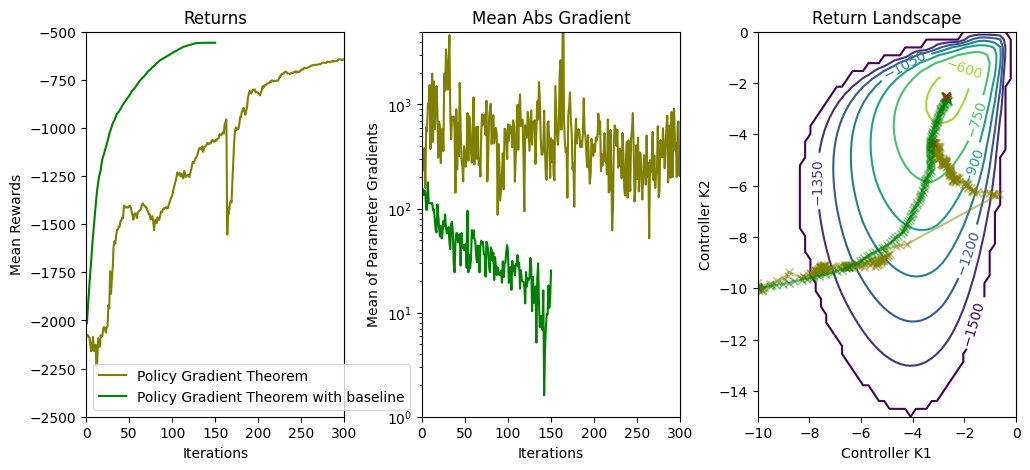

In [11]:
##### DO NOT CHANGE #####
N_ITERS = 300
N_ITERS_W_BASELINE = 150
BATCH_SIZE = 25

fig, axs = create_figure(n_iters=N_ITERS)
lines = add_method(axs, label="Policy Gradient Theorem", color="olive")

pgt = PolicyGradientTheorem(
    env=linear_env,
    policy=LinPolicy(),
    n_iters=N_ITERS,
    batch_size=BATCH_SIZE,
    lr=1e-4,
    baseline=False,
)
pgt_results = pgt.train(fig, *lines)

lines = add_method(axs, label="Policy Gradient Theorem with baseline", color="green")

pgt_with_baseline = PolicyGradientTheorem(
    env=linear_env,
    policy=LinPolicy(),
    n_iters=N_ITERS_W_BASELINE,
    batch_size=BATCH_SIZE,
    lr=1e-3,
    baseline=True,
)
pgt_with_baseline_results = pgt_with_baseline.train(fig, *lines)

save_figure(fig, "policy_gradient_theorem")

##### DO NOT CHANGE #####

In [12]:
##### DO NOT CHANGE #####
# ID: test_ex_2 - possible points: 3

# Test cell for Policy Gradient Theorem implementation
test_env_pgt = LinEnv()
test_policy_pgt = LinPolicy()
test_policy_pgt.update_params(np.array([-5, -5, 1]))

# Test Policy Gradient Theorem without baseline
pgt_test = PolicyGradientTheorem(
    env=test_env_pgt,
    policy=test_policy_pgt,
    n_iters=1,
    batch_size=5,
    lr=1e-4,
    baseline=False,
)
rng_test_pgt = np.random.default_rng(SEED)
states_test_pgt, actions_test_pgt, rewards_test_pgt = pgt_test.collect_policy_samples(rng_test_pgt)
grad_test_pgt = pgt_test.estimate_grad(states_test_pgt, actions_test_pgt, rewards_test_pgt)

assert grad_test_pgt.shape == (3,), "Gradient should have shape (3,) for 3 parameters"
assert not np.all(grad_test_pgt == 0), "Gradient should not be all zeros"
assert np.all(np.isfinite(grad_test_pgt)), "Gradient should not contain NaN or inf"

# Test Policy Gradient Theorem with baseline
pgt_test_baseline = PolicyGradientTheorem(
    env=test_env_pgt,
    policy=LinPolicy(),
    n_iters=1,
    batch_size=5,
    lr=1e-3,
    baseline=True,
)
grad_test_pgt_baseline = pgt_test_baseline.estimate_grad(states_test_pgt, actions_test_pgt, rewards_test_pgt)
assert grad_test_pgt_baseline.shape == (3,), "Gradient with baseline should have shape (3,)"
assert np.all(np.isfinite(grad_test_pgt_baseline)), "Gradient with baseline should not contain NaN or inf"

print("✓ Basic tests passed for Policy Gradient Theorem")


##### DO NOT CHANGE #####

N  5
H  50
N  5
H  50
✓ Basic tests passed for Policy Gradient Theorem


### Self-Test Questions (optional)

How do the performance and stability compare to the REINFORCE algorithm?

What happens if you increase or decrease the learning rate for the case with and without a baseline?

## Task 3: Natural Policy Gradient (3 Points)

A common approach in policy search is to apply a trust region constraint, where the policy update is bounded.
It has been shown that trust regions highly stabilize the learning process. 

A trust region approach which can be applied to continous control problems with parametric policy distributions is **Natural Policy Gradient**.
Here, the KL-constraint is approximated with the second order Taylor approximation, which results in the **Fisher Information** matrix $F$.

Concretely, we can calculate $F$ as 
\begin{align}
    \boldsymbol{F} = \frac{1}{NH} \sum_i^N \sum_t^H \left[\nabla_{\theta}\log \pi_{\theta}(a_{i,t}|s_{i,t})\nabla_{\theta}\log \pi_{\theta}(a_{i,t}|s_{i,t})^T\right].
\end{align}

The policy's parameter update is then given as
\begin{align}
    \boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha\boldsymbol{F}^{-1}\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}),
\end{align}
where for the gradient estimate $\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$ standard techniques like the policy gradient theorem are used.

In Natural Policy Gradient, the learning rate parameter $\alpha ~~(\eta^{-1}\text{ in the slides})$ can be solved in closed-form by finding the optimal solution of the dual function to the according Lagrangian (see Task 4). More specifically, $\alpha$ is given as 
\begin{align}
    \alpha = \sqrt{\frac{4\epsilon}{\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})^{T}\boldsymbol{F}^{-1}\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})}},
\end{align}
where $\epsilon$ is the hyperparameter, bounding the expected KL between the new and the old policy.

Since we will use the gradient estimate from the **Policy Gradient Theorem**, the following class inherits from the **PolicyGradientTheorem** class, i.e. you need to have properly solved Task 2 in order to be able to solve this task.

Implement the function `get_fisher_information()`, which will return the Fisher information matrix given state-action trajectories.
Apply the equations mentioned above.
Then implement the function `grad_ascent_step()`, which calculates and returns the new parameters of the policy according to the update rule mentioned above.
When implementing the update, please also use the closed-form solution to $\alpha$ to scale the update.

*Note: You will need to have properly solved Task 2 in order to be able to solve this task.*

*Hint: To get the gradient of the log policy for current state $\boldsymbol{s}_{i,t}$ and current action $a_{i,t}$ from the rollout i at time step t, you will need to call `self.policy.grad_log_pi(current_state, current_action)`, where current_state is $\boldsymbol{s}_{i,t}$ and current action is $a_{i,t}$.*

After you completed the implementation, run the cell.
During training, it plots the reward curve, the magnitude of the gradients, and the trajectory of the parameters through the parameter space.

In [13]:
class NaturalPolicyGradient(PolicyGradientTheorem):
    def __init__(
        self,
        *args,
        eps: float,
        **kwargs,
    ) -> None:
        # we don't use lr in natural gradient, so set to zero
        super().__init__(*args, lr=0.0, **kwargs)
        self.eps = eps

    def get_fisher_information(
        self,
        states: np.ndarray,
        actions: np.ndarray,
    ) -> np.ndarray:
        """
        This function calculates the Fisher Information matrix.
        :param states: all states of the last iteration: np.ndarray
                     [batch_size x HORIZON x S_DIM], where S_DIM is the state dimension
        :param actions: all taken actions of the last iteration: np.ndarray
                     [batch_size x HORIZON x A_DIM], A_DIM is the action dimension
        :return: F: returns the Fisher information matrix: np.ndarray [n_params x n_params]
        """
        ## Compute the Fisher information matrix below
        # F = ...
        
        # YOUR CODE HERE
        N,H,_=states.shape
        #grad_pi = self.policy.grad_log_pi(states,actions)
        #print("grad pi ", grad_pi.shape)
        #print("grad pi T ", grad_pi.T.shape)
        #F = 1/(N*H) * np.sum(np.sum(grad_pi*grad_pi.T,axis=1),axis=0)
        F = np.zeros((3,3))
        for i in range(N):
            t_sum = np.zeros((3,3))
            for t in range(H):
                grad_log = self.policy.grad_log_pi(states[i,t],actions[i,t])
                grad_log_2 = np.outer(grad_log,grad_log)
                t_sum += grad_log_2
            F+=t_sum
        F/=N*H
            
        print("F ",F)

        assert F.shape == (3, 3)
        return F

    def grad_ascent_step(
        self,
        grad_estimates: np.ndarray,
        states: np.ndarray,
        actions: np.ndarray,
    ) -> np.ndarray:
        """
        Performs an updated on the parameters of the policy according to the Natural Policy Gradient Rule by using
        the current gradient estimate (grad_estimate) of the Policy Gradient theorem with baseline, the
        state trajectories and the action trajectories.
        :param grad_estimates: estimates of the gradients for all parameters:
            np.ndarray [n_params]
        :param states all states of the last iteration:
            np.ndarray [batch_size x HORIZON x S_DIM], where S_DIM is the state dimension
        :param actions all taken actions of the last iteration:
            np.ndarray [batch_size x HORIZON x A_DIM], where A_DIM is the action dimension
        :return: updated policy parameters: np.ndarray [n_params]
        """
        ## Update the parameters
        #new_policy_params = ...
        
        # YOUR CODE HERE
        F_inv = np.linalg.pinv(self.get_fisher_information(states,actions))
        alpha = np.sqrt(4*self.eps / (grad_estimates @ F_inv @ grad_estimates.T))
        new_policy_params = self.policy.params + alpha * F_inv@grad_estimates

        assert new_policy_params.shape == (3,)
        return new_policy_params

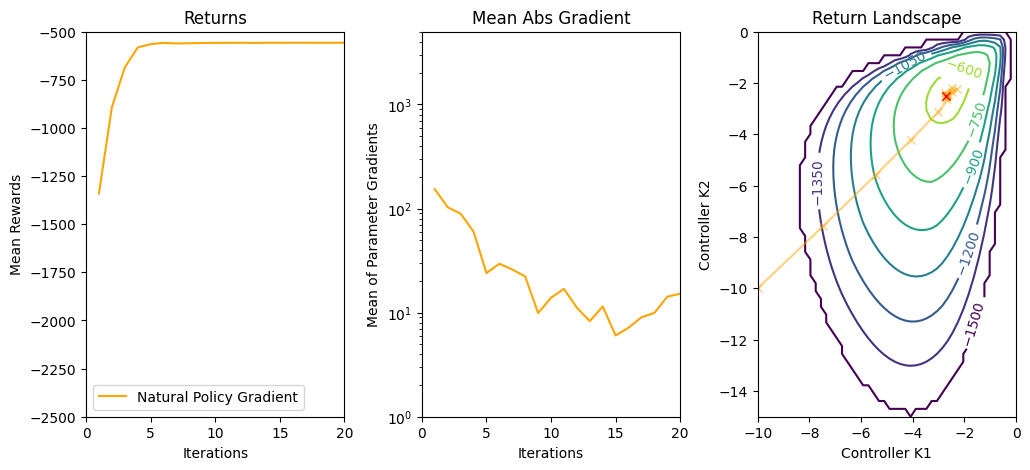

In [14]:
##### DO NOT CHANGE #####
N_ITERS_NG = 20
BATCH_SIZE = 25

fig, axs = create_figure(n_iters=N_ITERS_NG)
lines = add_method(axs, label="Natural Policy Gradient", color="orange")

npg = NaturalPolicyGradient(
    env=linear_env,
    policy=LinPolicy(),
    n_iters=N_ITERS_NG,
    batch_size=BATCH_SIZE,
    eps=0.5,
    baseline=True,
)
npg_results = npg.train(fig, *lines)

save_figure(fig, "natural_policy_gradient")

##### DO NOT CHANGE #####

In [15]:
##### DO NOT CHANGE #####
# ID: test_ex_3 - possible points: 3

# Test cell for Natural Policy Gradient implementation
test_env_npg = LinEnv()
test_policy_npg = LinPolicy()
test_policy_npg.update_params(np.array([-5, -5, 1]))

# Test Fisher Information Matrix
npg_test = NaturalPolicyGradient(
    env=test_env_npg,
    policy=test_policy_npg,
    n_iters=1,
    batch_size=5,
    eps=0.5,
    baseline=True,
)
rng_test_npg = np.random.default_rng(SEED)
states_test_npg, actions_test_npg, rewards_test_npg = npg_test.collect_policy_samples(rng_test_npg)

# Test get_fisher_information
fisher_test = npg_test.get_fisher_information(states_test_npg, actions_test_npg)
assert fisher_test.shape == (3, 3), "Fisher information matrix should have shape (3, 3)"
assert np.allclose(fisher_test, fisher_test.T), "Fisher information matrix should be symmetric"
assert np.all(np.linalg.eigvals(fisher_test) > 0), "Fisher information matrix should be positive definite"

# Test grad_ascent_step
grad_test_npg = npg_test.estimate_grad(states_test_npg, actions_test_npg, rewards_test_npg)
new_params = npg_test.grad_ascent_step(grad_test_npg, states_test_npg, actions_test_npg)
assert new_params.shape == (3,), "Updated parameters should have shape (3,)"
assert np.all(np.isfinite(new_params)), "Updated parameters should not contain NaN or inf"
assert not np.allclose(new_params, npg_test.policy.params), "Parameters should be updated"

print("✓ Basic tests passed for Natural Policy Gradient")


##### DO NOT CHANGE #####

F  [[ 0.76086029 -0.52439756 -0.01762365]
 [-0.52439756  0.61509439 -0.0520497 ]
 [-0.01762365 -0.0520497   1.83680685]]
N  5
H  50
F  [[ 0.76086029 -0.52439756 -0.01762365]
 [-0.52439756  0.61509439 -0.0520497 ]
 [-0.01762365 -0.0520497   1.83680685]]
✓ Basic tests passed for Natural Policy Gradient


### Self-Test Questions (optional)

How does this algorithm compare to the two first-order methods used earlier?

What happens if you increase or decrease `eps` (comparable to the learning rate)?
How does the algorithm respond to different batch sizes?

The use of a baseline made a massive difference with the first-order methods used earlier.
What happens if you remove the baseline here?
Can you tune the hyperparameters such that it converges anyway?

The following cell will plot the results from all algorithms into one plot.

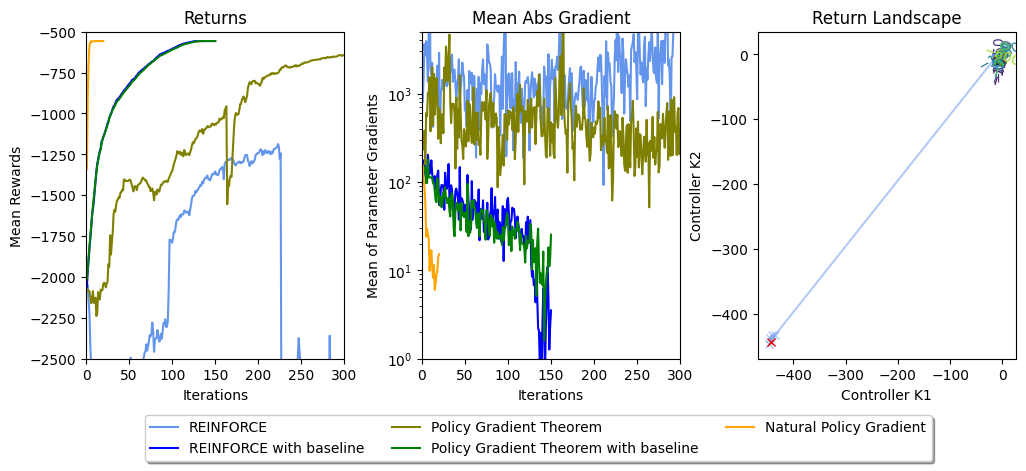

In [16]:
##### DO NOT CHANGE #####
# plot all algorithms in one plot
fig, axs = create_figure(n_iters=300)
plot_all_results(
    axs,
    results=[
        reinforce_results,
        reinforce_with_baseline_results,
        pgt_results,
        pgt_with_baseline_results,
        npg_results,
    ],
    labels=[
        "REINFORCE",
        "REINFORCE with baseline",
        "Policy Gradient Theorem",
        "Policy Gradient Theorem with baseline",
        "Natural Policy Gradient",
    ],
    colors=["cornflowerblue", "blue", "olive", "green", "orange"],
)

save_figure(fig, "all")

##### DO NOT CHANGE #####

## Task 4: Policy Gradients with Neural Network Policies

The environment and policy we were using until now were relatively impractical for practical use.
Instead of a linear stochastic controller, we usually use a neural network policy, making it tedious to compute the gradient explicitly.
Also, inverting the Fisher Information matrix $F$ becomes too computationally intensive, since matrix inversion is an $O(n^3)$ algorithm, where $n$ is the number of parameters.

Let's consider training neural network policies to solve the discrete pole balancing environment called 'CartPole'.
We will use the ['CartPole-v1' environment from Gymnasium](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

![The CartPole Environment](https://gymnasium.farama.org/_images/cart_pole.gif)

We will use the **REINFORCE** algorithm **with baselines** and **policy gradient theorem** as shown below. 

---

- **Repeat**  For $k=1, 2, \dots$
    - Run policy to sample trajectories \{$\tau_i$\}, ${i=1,...,N}$ from $\pi_{\boldsymbol{\theta}}(a|\boldsymbol{s})$
    - Estimate the gradient:
$\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta}) \approx \frac{1}{N} \sum_i^N \sum_t^H \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a_{i,t}|\boldsymbol{s}_{i,t}) \left(Q_t - b_t \right)$
    - Update the parameters:
$\boldsymbol{\theta}\leftarrow \boldsymbol{\theta} + \alpha \nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$

- **Until convergence**

---
This equation is quite similar to what we used before.
The difference here is that our policy $\pi_{\boldsymbol{\theta}}$ is no longer a linear controller but a non-linear neural network.
Since we are using neural networks, we will no longer compute the gradient explicitly, but instead let autograd do it for us.
Instead of computing $\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$, we now need to compute a "loss function" $J(\boldsymbol{\theta})$, such that its gradient is the gradient estimate we want.
Autograd will then compute $\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$ for us implicitly.

Also, we've generalized the return estimate to the form $(Q_t - b_t)$, where $Q_t$ is some estimate of the Q value at time $t$ (e.g. return to go), while $b_t$ is some baseline (but may be no baseline).

We first import the necessary packages.

In [17]:
##### DO NOT CHANGE #####
from collections import deque

import gymnasium as gym
import torch
import torch.distributions as distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


def train_once(
    env: gym.Env,
    policy: nn.Module,
    discount: float,
    baseline: bool,
    pg_theorem: bool,
) -> tuple[float, float]:
    policy.train()

    log_prob_actions: list[torch.Tensor] = []
    rewards: list[float] = []

    state, info = env.reset()
    terminated = truncated = False

    while not (terminated or truncated):
        state = torch.from_numpy(state).to(DEVICE).unsqueeze(dim=0)

        # get logits from neural network (unnormalized probabilities)
        action_logits = policy(state)

        # create a probability distribution using softmax on the logits
        action_prob = F.softmax(action_logits, dim=-1)

        # Sample discrete actions from a categorical distribution
        # https://pytorch.org/docs/stable/distributions.html
        dist = distributions.Categorical(action_prob)

        # sample an action (without gradients)
        action = dist.sample()

        # Use distribution object to compute log probabilities for the sampled actions.
        # These values have gradients and are used for optimization
        log_prob_action = dist.log_prob(action)

        state, reward, terminated, truncated, info = env.step(
            action.squeeze(dim=0).cpu().numpy()
        )

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)

    returns = calculate_returns(rewards, discount, baseline, pg_theorem)

    loss = update_policy(
        returns=torch.from_numpy(returns).to(DEVICE),
        log_prob_actions=torch.cat(log_prob_actions),
    )

    return loss, returns[0].item()


def evaluate_policy(envs: gym.Env, policy: nn.Module) -> float:
    policy.eval()

    return_ = 0

    state, info = envs.reset()
    terminated = truncated = False

    while not (terminated or truncated):
        state = torch.from_numpy(state).to(DEVICE).unsqueeze(dim=0)

        with torch.no_grad():
            # get logits from neural network (unnormalized probabilities)
            action_logits = policy(state)

        # create a probability distribution using softmax on the logits
        action_prob = F.softmax(action_logits, dim=-1)

        # select the action with the highest probability
        action = torch.argmax(action_prob, dim=-1)

        state, reward, terminated, truncated, info = envs.step(
            action.squeeze(dim=0).cpu().numpy()
        )

        return_ += reward

    return return_

##### DO NOT CHANGE #####

### Task 4.1: Building a Neural Network in PyTorch (2 points)
    
This part of the code creates a feed forward neural network using PyTorch, which will form the policy  $\pi_{\boldsymbol{\theta}}(a|\boldsymbol{s})$.

Implement the `__init__` method of the `MLP` class, which creates the neural network as a sequence of alternating `torch.nn.Linear` and `torch.nn.ReLU` layers.
After the `__init__` method, `MLP` should have a `network` attribute which is a `torch.nn.Sequential` object.
The neural network should have `input_size` input nodes, then hidden layers with sizes dictated by `hidden_sizes`, and finally `output_size` output nodes.


In [18]:
class MLP(nn.Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_sizes: list[int],
    ) -> None:
        """
        :param state_dim: dimension of the state space
        :param state_dim: dimension of the actions
        :param hidden_units: list of integers corresponding to hidden units
        """
        super().__init__()

        ## Build your network
        # self.network = ...
        
        # YOUR CODE HERE
        self.network = torch.nn.Sequential(torch.nn.Linear(in_features=input_size, out_features=hidden_sizes[0]),
                                           torch.nn.ReLU()
                                           )
        
        for i in range(len(hidden_sizes)-1):
            self.network.extend(torch.nn.Sequential(torch.nn.Linear(in_features=hidden_sizes[i], out_features=hidden_sizes[i+1]),torch.nn.ReLU()))
        self.network.extend(torch.nn.Sequential(torch.nn.Linear(in_features=hidden_sizes[-1], out_features=output_size)))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """forward pass of decoder
        :param input:
        :return: output mean
        """
        return self.network(input)

In [19]:
##### DO NOT CHANGE #####
# ID: test_ex_4a - possible points: 2

# Test cell for MLP implementation
import torch
import torch.nn as nn

# Test MLP structure
test_mlp = MLP(input_size=4, output_size=2, hidden_sizes=[8, 4])
assert hasattr(test_mlp, 'network'), "MLP should have a 'network' attribute"
assert isinstance(test_mlp.network, nn.Sequential), "network should be a nn.Sequential"

# Test forward pass
test_input = torch.randn(1, 4)
test_output = test_mlp(test_input)
assert test_output.shape == (1, 2), f"Output shape should be (1, 2), got {test_output.shape}"

# Count layers (Linear + ReLU, but last layer has no ReLU)
expected_layers = len([8, 4]) * 2 + 1  # 2 hidden layers with ReLU each + 1 output layer
assert len(list(test_mlp.network)) == expected_layers, f"Expected {expected_layers} layers, got {len(list(test_mlp.network))}"

print("✓ Basic tests passed for MLP")


##### DO NOT CHANGE #####

✓ Basic tests passed for MLP


### Computing Q-values
The code block computes numpy arrays for Q-values which will be used to weight the $\nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a_{i,t}|\boldsymbol{s}_{i,t})$ of each time step.

Recall that the expression for the policy gradient "loss" is

\begin{align}
    J = \text{E}_{\tau\sim p(\tau)}\left[\sum_{t=0}^H \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a_{i,t}|\boldsymbol{s}_{i,t}) (Q_t-b_t)\right],
\end{align}
where $ \tau=(s_0, a_0, ...)$ is a trajectory, $Q_t$ is the Q-value at time $t$ and $b_t$ is a baseline.


We can obtain four different cases, depending on whether we use returns to returns to go and whether we subtract a baseline or not:

**Case 1: REINFORCE (pg_theorem = False)**

Here we estimate $Q_t$ by the total discounted return for the entire trajectory, regardless of which time step the Q-value should be for. Therefore, the Q estimator is

\begin{align}
    Q_t = \text{R}(\tau) = \sum_{k=0}^H r_{k},
\end{align}

**Case 2: Policy Gradient Theorem (pg_theorem = True)**

Here, we subtract out any rewards from the past, since they cannot have resulted from the current action. Thus, the Q estimator is

\begin{align}
    Q_t = \text{R}(\tau_{k \gt t}) = \sum_{k=t}^H r_{k}
\end{align}

**Case 3: No Baseline (baseline = False)**

Here we use the absolute $Q_t$ as is, with the baseline set to 0:

\begin{align}
    b_t = 0
\end{align}

**Case 4: With baseline (baseline = True)**

We can subtract any baseline from the $Q_t$ as long as it doesn't depend on the trajectory. In this example, since we only have one environment, we take the mean of the $1000$ most recent $Q$ values.

\begin{align}
    b_t = \frac{1}{N}\sum_i^{N} Q_t
\end{align}

In [20]:
##### DO NOT CHANGE #####
def calculate_returns(
    rewards: list[float],
    discount: float,
    baseline: bool,
    pg_theorem: bool,
) -> np.ndarray:
    returns = []
    return_ = 0
    for reward in reversed(rewards):
        return_ = reward + return_ * discount
        returns.append(return_)
    returns.reverse()

    if not pg_theorem:
        returns = returns[:1] * len(returns)

    returns = np.array(returns)

    if baseline:
        RECENT_RETURNS.extend(returns)
        mean_return = np.mean(RECENT_RETURNS)
        returns = returns - mean_return

    return returns

##### DO NOT CHANGE #####

### Task 4.2: Computing Loss (1 Points)

Here we create a "pseudoloss" which is the weighted maximum likelihood, $\sum_{t=0}^T \log \pi_{\theta}(a_t|s_t)  (Q_t - b_t )$, using the stored `log_prob_actions` and `returns` values computed in the previous section.
The gradient of this loss function with respect to the neural network parameters ($\theta$) is the policy gradient.

In [21]:
def update_policy(
    returns: torch.Tensor,
    log_prob_actions: torch.Tensor,
) -> float:
    """
    This function calculates the loss and backpropagate the errors using pytorch optmizers.
    :param returns: returns (maybe with a baseline) received from the previous trajectory
        torch.Tensor [HORIZON]
    :param log_prob_actions: log probability of each action from the previous trajectory
        torch.Tensor [HORIZON]
    :param optimizer: the torch optimizer object https://pytorch.org/docs/stable/optim.html
    :return: magnitude of calculated loss (float)
    """

    ## Compute the loss
    loss = -torch.sum(log_prob_actions*returns)
    
    # YOUR CODE HERE

    ## Backpropagate using pytorch autograd. We will use the Adam Optimizer to do this, though any optimizer
    ## would work in practice.
    OPTIMIZER.zero_grad()
    loss.backward()
    OPTIMIZER.step()
    return loss.item()

In [22]:
##### DO NOT CHANGE #####
# ID: test_ex_4b - possible points: 1

# Test cell for update_policy implementation
import torch
import torch.distributions as distributions

# Create a simple test case
test_returns_update = torch.tensor([1.0, 2.0, 3.0])
test_log_probs = torch.tensor([-0.5, -0.3, -0.2], requires_grad=True)

# Test that loss is computed correctly
test_policy_update = MLP(input_size=4, output_size=2, hidden_sizes=[8])
test_optimizer_update = torch.optim.Adam(test_policy_update.parameters(), lr=1e-3)
OPTIMIZER = test_optimizer_update

loss_value = update_policy(test_returns_update, test_log_probs)

assert isinstance(loss_value, float), "Loss should be a float"
assert loss_value != 0.0, "Loss should not be zero for non-zero returns and log probs"

# Check that gradient was computed
assert test_log_probs.grad is not None, "Gradients should be computed"

print("✓ Basic tests passed for update_policy")


##### DO NOT CHANGE #####

✓ Basic tests passed for update_policy


### Hyperparameters, run training, and plot reward curve

We run the algorithm 5 times with different random seeds, and plot the mean reward curve with min/max bounds.

You can play around with the hyperparameters and see how each of these affect the algorithms performance. However, please submit the saved figures with the default parameters given here.

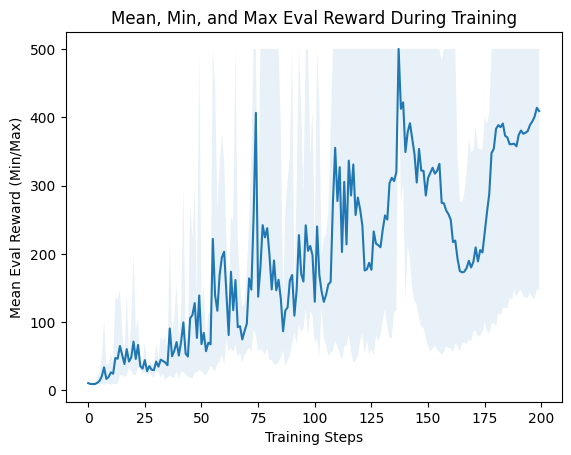

In [23]:
##### DO NOT CHANGE #####
rl_env = gym.make("CartPole-v1")

# Hyperparameters
# learning
baseline = True
pg_theorem = True
learning_rate = 5e-3
discount = 0.99

# network architecture
input_dim = rl_env.observation_space.shape[0]
output_dim = rl_env.action_space.n
hidden_sizes = [32, 16]

# training length and accelerator
N_RUNS = 5
N_ITERATIONS = 200
DEVICE = torch.device("cpu")
all_train_returns = []
all_test_returns = []

# seeding
rl_env.reset(seed=SEED)
torch.manual_seed(SEED)

# setup plotting
fig, ax = plt.subplots()

for run in range(N_RUNS):
    policy = MLP(input_dim, output_dim, hidden_sizes).to(DEVICE)
    OPTIMIZER = optim.Adam(policy.parameters(), lr=learning_rate)
    RECENT_RETURNS = deque(maxlen=1000)

    train_returns = np.zeros((N_ITERATIONS,))
    test_returns = np.zeros((N_ITERATIONS,))
    for episode in range(N_ITERATIONS):
        loss, train_reward = train_once(rl_env, policy, discount, baseline, pg_theorem)

        test_reward = evaluate_policy(rl_env, policy)

        train_returns[episode] = train_reward
        test_returns[episode] = test_reward

    # update plots
    display.clear_output(wait=True)
    all_train_returns.append(train_returns)
    all_test_returns.append(test_returns)
    ax.clear()
    ax.plot(np.mean(all_test_returns, axis=0))
    ax.fill_between(
        np.arange(N_ITERATIONS),
        np.min(all_test_returns, axis=0),
        np.max(all_test_returns, axis=0),
        alpha=0.1,
    )
    ax.set(
        title="Mean, Min, and Max Eval Reward During Training",
        xlabel="Training Steps",
        ylabel="Mean Eval Reward (Min/Max)",
    )
    display.display(fig)

# clear duplicate plot
display.clear_output()

save_figure(fig, "deep_policy_gradients")

##### DO NOT CHANGE #####

### Self-Test Questions (optional)

Play with the hyperparameters for this algorithm if you wish.

What happens if you make the neural network much larger, e.g. `hidden_sizes = [128, 128, 128]`?
Why?
What can we do to ensure that learning is stable despite bigger and deeper networks?